In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer

In [2]:
st = SentenceTransformer("xlm-r-bert-base-nli-stsb-mean-tokens")
data = pd.read_csv("./comments.csv")

comments = data[['textClean', 'videoId']]

text = comments["textClean"].values.tolist()
labels = comments.index.to_list()

dico_font_video = {}

for i, videoid in enumerate(comments.videoId.unique()):
    dico_font_video[videoid] = i

font = [dico_font_video[videoid] for videoid in comments.videoId]

In [3]:
embs = st.encode(text)
pca = PCA(2).fit_transform(embs)

In [4]:
kmeans = KMeans(5, n_init=80, max_iter=2000).fit(embs)

In [5]:
center_indices = [
    int(np.argmin([np.sum((x-centroid)**2) for x in embs]))
    for centroid in kmeans.cluster_centers_]

commentaires_representants = [comments.textOriginal[i] for i in center_indices]
representants = ''
for i, comment in enumerate(commentaires_representants):
    representants += f'{i}:{comment} \n'
print(representants)

0:un régal, comme d'hab! Merci pour ce très beau travail 
1:J'adore! Une super vidéo encore une fois ! Merci pour ce que tu fais et la qualité de ton travail 
2:J'adore tes vidéos mecs, t'es un scientifique, moi j'y comprends rien ! Mais...les flamands rose existent !? Moi pas comprendre.
Au fait : tu me fais délirer avec tes montages ! J'ai adoré le ''Ta gueule !'' 
3:Le montage est toujours aussi bon c’est ouf 🤌🏼 
4:Merci pour ton travail de recherche et de vulgarisation ❤️ 



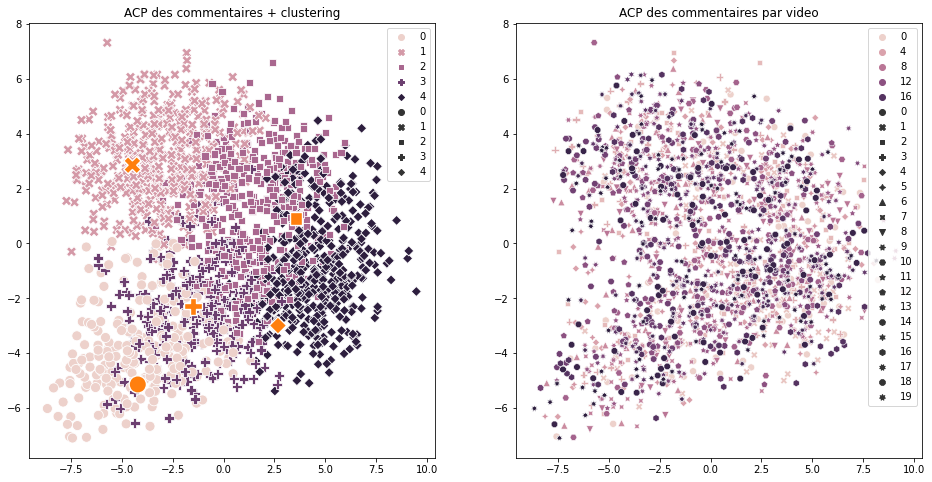

0:un régal, comme d'hab! Merci pour ce très beau travail 
1:J'adore! Une super vidéo encore une fois ! Merci pour ce que tu fais et la qualité de ton travail 
2:J'adore tes vidéos mecs, t'es un scientifique, moi j'y comprends rien ! Mais...les flamands rose existent !? Moi pas comprendre.
Au fait : tu me fais délirer avec tes montages ! J'ai adoré le ''Ta gueule !'' 
3:Le montage est toujours aussi bon c’est ouf 🤌🏼 
4:Merci pour ton travail de recherche et de vulgarisation ❤️ 



In [6]:
plt.subplots(figsize=(16, 8))
plt.subplot(121)
sns.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=kmeans.labels_, style=kmeans.labels_, s=100)
sns.scatterplot(x = [pca[i, 0] for i in center_indices], 
                y=[pca[i, 1] for i in center_indices],
                style = [i for i in range(len(center_indices))], 
                s=300)
plt.title("ACP des commentaires + clustering")

plt.subplot(122)
sns.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=font, style=font, s=50)
plt.title("ACP des commentaires par video")

plt.show()
print(representants)

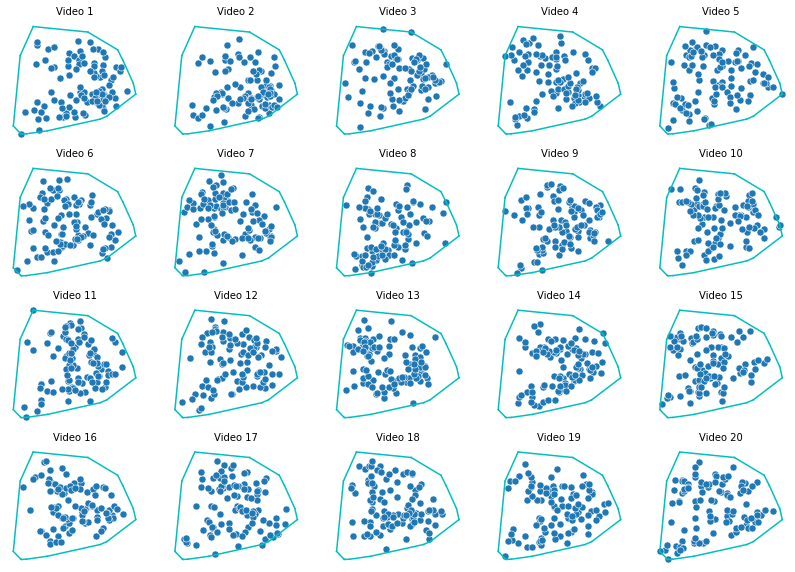

In [7]:
from scipy.spatial import ConvexHull

hull = ConvexHull(pca)

fig, axs = plt.subplots(4, 5, figsize=(14, 10))
for i, ax in enumerate(np.array(axs).flatten()):
    sns.scatterplot(x=[pca[j, 0] for j in range(len(font)) if font[j] == i],
                    y=[pca[j, 1] for j in range(len(font)) if font[j] == i],
                    s=50,
                    ax=ax)
    for simplex in hull.simplices:
            ax.plot(pca[simplex, 0], pca[simplex, 1], 'c')
    ax.set_title(f'Video {i+1}', fontsize=10)
    ax.axis('off')
plt.show()

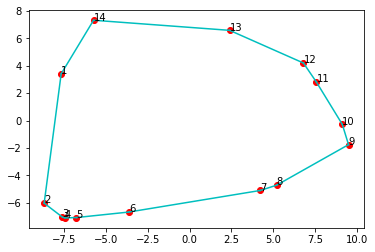

1 : Encore merci pour tes vidéos, elles sont vraiment géniale !
 2 : wow, really well done job! thank you for your great work!
 3 : merci beaucoup, très beau travail
 4 : Merci beaucoup pour ce que vous faites ;-)
 5 : Hyper intéressant. Merci ! Et en plus, j'ai bien ri
 6 : Wesh, ça tombait bien, je cherchais un centre d'épilation au laser ! Merci Fazze !
 7 : "Le blanc non plus n'existe pas"
Marine Le Pen : "Pardon ?!"
 8 : Et pourquoi pas appeler l'oiseau Louis-Antoine en hommage à Bougainville, l'homme ET le bateau !
 9 : Birdy Biology au beau milieu de son trajet: "Merde! j'ai pensé à éteindre le four ou pas?"
 10 : J'ai longtemps eu la phobie des chiens. Mes parents ne l'ont jamais compris car je n'ai jamais été attaquée (mais j'ai grandi avec une cousine qui elle c'était faite bouffer la joue par un molosse lorsqu'elle était bébé, et ils n'ont jamais vu le lien) :D En grandissant j'avais de plus en plus peur de tout un tas de choses et surtout des animaux, mais ma grande phobie 

In [45]:
for simplex in hull.simplices:
    plt.plot(pca[simplex, 0], pca[simplex, 1], 'c')
bound = np.array([pca[i] for i in hull.vertices])
plt.scatter(x=bound[:,0], y=bound[:,1], color='r')
for name, vect in zip(range(len(bound)), bound):
    plt.annotate(name+1, vect)
plt.show()
print(*[f'{i+1} : ' + text[ind]+'\n' for i,ind in enumerate(hull.vertices)])

In [23]:
hull.vertices

array([ 367, 1930,   46, 1982, 1048,  700, 1629,  510,  401,  925,  747,
       1305,  290, 1093], dtype=int32)